In [ ]:
# default_exp capture_annotator

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

In [ ]:
# hide
from nbdev import *

In [ ]:
#exporti

import math
import warnings
from functools import partial
from pathlib import Path
from typing import Dict, Optional, List

from IPython.core.display import display
from ipywidgets import (AppLayout, VBox, HBox, Button, GridBox,
                        Layout, Checkbox, HTML, IntText, Output)

from ipyannotator.base import BaseState, AppWidgetState
from ipyannotator.image_button import ImageButton
from ipyannotator.navi_widget import Navi
from ipyannotator.storage import JsonCaptureStorage

# Capture annotator

The current notebook develop a annotator (`Capture Annotator`) that displays multiple items options, allowing users to select multiple of them and save their answers.

## State

The data shared across the annotator are:

- The `annotations` attribute represents all annotations that could be selected and the user's answers;
- The `disp_number` attribute represents the number of options to be displayed;
- The `question_value` attribute represents the label to be shown above the selectable options;
- The `all_none` attribute represents that no option was selected;
- The `n_rows` and `n_cols` displays the number of options to be shows per rows and cols respectively.

In [ ]:
#exporti

class CaptureState(BaseState):
    annotations: Dict[str, Optional[Dict[str, bool]]] = {}
    disp_number: int = 9
    question_value: str = ''
    all_none: bool = False
    n_rows: int = 3
    n_cols: int = 3

## View

For the view an internal component called ` CaptureGrid ` it's developed, this component allows us to display the options on screen.  

In [ ]:
#export

class CaptureGrid(GridBox):
    """
    Represents grid of `ImageButtons` with state.

    """
    debug_output = Output(layout={'border': '1px solid black'})

    def __init__(self, grid_item=ImageButton, image_width=150, image_height=150,
                 n_rows=3, n_cols=3, display_label=False):

        self.image_width = image_width
        self.image_height = image_height
        self.n_rows = n_rows
        self.n_cols = n_cols
        self._screen_im_number = IntText(value=n_rows * n_cols,
                                         description='screen_image_number',
                                         disabled=False)

        self._labels = [grid_item(
            display_label=display_label, image_width='%dpx' % self.image_width,
            image_height='%dpx' % self.image_height) for _ in range(self._screen_im_number.value)]

        self.callback = None

        gap = 40 if display_label else 15

        centered_settings = {
            'grid_template_columns': " ".join(["%dpx" % (self.image_width + gap) for i
                                               in range(self.n_cols)]),
            'grid_template_rows': " ".join(["%dpx" % (self.image_height + gap) for i
                                            in range(self.n_rows)]),
            'justify_content': 'center',
            'align_content': 'space-around'
        }

        super().__init__(children=self._labels, layout=Layout(**centered_settings))

    @debug_output.capture(clear_output=True)
    def load_annotations_labels(self, annotations: dict = None):
        iter_state = iter(annotations)

        for label in self._labels:
            p = next(iter_state, None)
            if p:
                label.image_path = str(p)
                label.label_value = Path(p).stem
                label.active = annotations[p].get('answer', False)
            else:
                label.clear()

        if self.callback:
            self.register_on_click()

    def on_click(self, cb: callable):
        self.callback = cb
        self.register_on_click()

    @debug_output.capture(clear_output=True)
    def register_on_click(self):
        for label in self._labels:
            label.reset_callbacks()
            label.on_click(partial(self.callback, name=label.name))

In [ ]:
ibg = CaptureGrid(grid_item=ImageButton, image_width=50, image_height=75)
ibg

You should not see anything at this step, until you set a correct visual state (see next step below)

In [ ]:
ibg.debug_output

The result will be similar to:

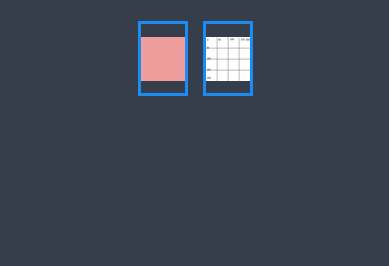

Actually `CaptureGrid` does not have own `on_click` event listener, but grid elements itself should implement `on_click(ev)` and `reset_callbacks()` methods to register/reset onclick callback function respectively. Also grid element shoudl have a field `name` in order user can destinguish between grid children.

In current implementation `ImageButton` is default grid element.

While ipyevents implementation lacks `sender` or `source` in callback args, `functools.partial` used to back element `name` into return value. You can see example of on_click event handler `test_handler` below. 
`name` of the button is printed out on click.

In [ ]:
# hide
annotations_on_state = {
    '../data/projects/capture1/pics/pink25x25.png': {'answer': True},
    '../data/mock/pics/test200x200.png': {'answer': True}, '': {'answer': False}
}

ibg.load_annotations_labels(annotations_on_state)

In [ ]:
# hide
h = HTML('Event info')
display(h)


def test_handler(event, name=None):
    event.update({'label_name': name})
    h.value = event['label_name']


ibg.on_click(test_handler)

The ` CaptureAnnotatorGUI ` joins the internal component (`CaptureGrid`) with the navi component and its interaction.

In [ ]:
#exporti

class CaptureAnnotatorGUI(AppLayout):
    """
    save_btn_clicked: callable
        activated when the user clicked on the save button
    grid_box_clicked: callable
        activated when the user clicked on the grid box
    on_navi_clicked: callable
        activated when the user navigates through the annotator
    """

    def __init__(
        self,
        app_state: AppWidgetState,
        capture_state: CaptureState,
        save_btn_clicked: callable = None,
        grid_box_clicked: callable = None,
        on_navi_clicked: callable = None,
        select_none_changed: callable = None
    ):
        self._app_state = app_state
        self._capture_state = capture_state
        self._save_btn_clicked = save_btn_clicked
        self._grid_box_clicked = grid_box_clicked
        self._select_none_changed = select_none_changed

        self._screen_im_number = IntText(
            value=self._capture_state.n_rows * self._capture_state.n_cols,
            description='screen_image_number',
            disabled=False
        )

        self._navi = Navi()

        self._save_btn = Button(description="Save",
                                layout=Layout(width='auto'))

        self._none_checkbox = Checkbox(description="Select none",
                                       indent=False,
                                       layout=Layout(width='100px'))

        self._controls_box = HBox(
            [
                self._navi,
                self._save_btn,
                self._none_checkbox,
            ],
            layout=Layout(
                display='flex',
                justify_content='center',
                flex_flow='wrap',
                align_items='center'
            )
        )

        self._grid_box = CaptureGrid(
            image_width=self._app_state.size[0],
            image_height=self._app_state.size[1],
            n_rows=self._capture_state.n_rows,
            n_cols=self._capture_state.n_cols,
            display_label=False
        )

        self._grid_label = HTML()
        self._labels_box = VBox(
            children=[
                self._grid_label,
                self._grid_box
            ],
            layout=Layout(
                display='flex',
                justify_content='center',
                flex_wrap='wrap',
                align_items='center'
            )
        )

        self._navi.on_navi_clicked = on_navi_clicked
        self._save_btn.on_click(self._btn_clicked)
        self._grid_box.on_click(self._grid_clicked)
        self._none_checkbox.observe(self._none_checkbox_changed, 'value')

        if self._capture_state.question_value:
            self._set_label(self._capture_state.question_value)

        if self._app_state.max_im_number:
            self._set_navi_max_im_number(self._app_state.max_im_number)

        if self._capture_state.annotations:
            self._grid_box.load_annotations_labels(self._capture_state.annotations)

        self._capture_state.subscribe(self._set_none_checkbox, 'all_none')
        self._capture_state.subscribe(self._set_label, 'question_value')
        self._app_state.subscribe(self._set_navi_max_im_number, 'max_im_number')
        self._capture_state.subscribe(self._grid_box.load_annotations_labels, 'annotations')

        super().__init__(
            header=None,
            left_sidebar=None,
            center=self._labels_box,
            right_sidebar=None,
            footer=self._controls_box,
            pane_widths=(2, 8, 0),
            pane_heights=(1, 4, 1))

    def _set_none_checkbox(self, all_none: bool):
        self._none_checkbox.value = all_none

    def _set_navi_max_im_number(self, max_im_number: int):
        self._navi.max_im_num = max_im_number

    def _set_label(self, question_value: str):
        self._grid_label.value = question_value

    def _btn_clicked(self, *args):
        if self._save_btn_clicked:
            self._save_btn_clicked(self._app_state.index)
        else:
            warnings.warn("Save button click didn't triggered any event.")

    def _none_checkbox_changed(self, change: dict):
        self._capture_state.set_quietly('all_none', change['new'])
        if self._select_none_changed:
            self._select_none_changed(change)

    def _grid_clicked(self, event, name=None):
        if self._grid_box_clicked:
            self._grid_box_clicked(event, name)
        else:
            warnings.warn("Grid box click didn't triggered any event.")

In [ ]:
# hide
app_state = AppWidgetState(**{'size': (50, 50)})
capture_state = CaptureState(**{'n_rows': 5, 'n_cols': 5})

ca = CaptureAnnotatorGUI(
    capture_state=capture_state,
    app_state=app_state
)

ca._grid_label.value = 'Select smth'

ca

In [ ]:
# hide
ca._capture_state.annotations = {
    '../data/projects/capture1/pics/pink25x25.png': {'answer': True}
}

In [ ]:
# hide
project_path = Path('../data/projects/capture1')

In [ ]:
# hide
from ipyannotator.mltypes import InputImage, OutputGridBox

imz = InputImage()
grid_bx = OutputGridBox()

In [ ]:
# hide

# it loads annotation labels when CaptureState.annotations changes
from pubsub import pub

pub.sendMessage('CaptureState.annotations', annotations={
    '../data/projects/capture1/pics/pink25x25.png': {'answer': False}
})

assert list(filter(lambda l: l.active, ca._grid_box._labels)) == []

# it throw warning if no btn_clicked callable is provided

with warnings.catch_warnings(record=True) as w:
    ca._save_btn.click()
    assert len(w) == 1
    assert "Save button click didn't triggered any event." in str(w[-1].message)

# it doesnt throw warning if btn_clicked callable is provided

with warnings.catch_warnings(record=True) as w:
    ca._save_btn_clicked = lambda index: index
    ca._save_btn.click()
    assert len(w) == 0

## Storage

The `CaptureAnnotationStorage` saves the user annotations on the disk

In [ ]:
#exporti

class CaptureAnnotationStorage:
    def __init__(
        self,
        input_item_path: Path,
        annotation_file_path: str
    ):
        self.input_item_path = input_item_path
        self.annotation_file_path = annotation_file_path

        self.annotations = JsonCaptureStorage(
            self.input_item_path,
            annotation_file_path=self.annotation_file_path
        )

    def __setitem__(self, key, value):
        self.annotations[key] = value

    def _save(self):
        self.annotations.save()

    def get_im_names(self, filter_files) -> List[str]:
        return self.annotations.get_im_names(filter_files)

    def get(self, path: str) -> dict:
        return self.annotations.get(path)

    def update_annotations(self, annotations: dict):
        for p, anno in annotations.items():
            self.annotations[str(p)] = anno
        self._save()

    def to_dict(self, only_annotated: bool = True) -> dict:
        return self.annotations.to_dict(only_annotated)

## Controller

The controller communicates with the state and the storage layer, updating the states and saving the data on disk using the storage module. 

In [ ]:
#exporti

class CaptureAnnotatorController:
    debug_output = Output(layout={'border': '1px solid black'})

    def __init__(
        self,
        app_state: AppWidgetState,
        capture_state: CaptureState,
        storage: CaptureAnnotationStorage,
        input_item=None,
        output_item=None,
        filter_files=None,
        question=None,
        *args,
        **kwargs
    ):
        self._app_state = app_state
        self._capture_state = capture_state
        self._storage = storage
        self.input_item = input_item
        self.output_item = output_item
        self._last_index = 0

        self._capture_state.subscribe(self.update_state, 'disp_number')
        self._capture_state.subscribe(self._calc_screens_num, 'disp_number')

        self.images = self._storage.get_im_names(filter_files)
        self.current_im_number = len(self.images)

        if question:
            self._capture_state.question_value = ('<center><p style="font-size:20px;"'
                                                  f'>{question}</p></center>')

        self.update_state(self._capture_state.disp_number)
        self._calc_screens_num(self._capture_state.disp_number)

    def update_state(self, disp_number: int):
        state_images = self._get_state_names(self._app_state.index)
        current_state = {}

        for im_path in state_images:
            current_state[str(im_path)] = self._storage.get(str(im_path)) or {}

        self._update_all_none_state(current_state)

        self._capture_state.annotations = current_state

    def _update_all_none_state(self, state_images: dict):
        self._capture_state.all_none = all(
            value == {'answer': False} for value in state_images.values()
        )

    def save_annotations(self, index: int):  # to disk
        state_images = self._capture_state.annotations

        self._storage.update_annotations(state_images)

    def _get_state_names(self, index: int) -> List[str]:
        start = index * self._capture_state.disp_number
        end = start + self._capture_state.disp_number
        im_names = self.images[start:end]
        return im_names

    def idx_changed(self, index: int):
        ''' On index change save old state
            and update current state for visualisation
        '''
        self._app_state.set_quietly('index', index)
        self.save_annotations(self._last_index)
        self.update_state(self._capture_state.disp_number)
        self._last_index = index

    def _calc_screens_num(self, disp_number: int):
        self._app_state.max_im_number = math.ceil(
            self.current_im_number / self._capture_state.disp_number
        )

    @debug_output.capture(clear_output=False)
    def handle_grid_click(self, event: dict, name=None):
        p = self._storage.input_item_path / name
        current_state = self._capture_state.annotations.copy()

        if not p.is_dir():
            state_answer = self._capture_state.annotations[str(p)].get('answer', False)
            current_state[str(p)] = {'answer': not state_answer}

            for k, v in current_state.items():
                if v == {}:
                    current_state[k] = {'answer': False}

            if self._capture_state.all_none:
                self._capture_state.all_none = False
            else:
                self._update_all_none_state(current_state)
        else:
            return

        self._capture_state.annotations = current_state

    def select_none(self, change: dict):
        if self._capture_state.all_none:
            self._capture_state.annotations = {p: {
                'answer': False} for p in self._capture_state.annotations}

In [ ]:
# remove if the results folder exists this allows
# the next command to construct the annotation path
! rm -rf ../data/projects/capture1/results

In [ ]:
from ipyannotator.storage import construct_annotation_path

anno_file_path = construct_annotation_path(project_path)

storage = CaptureAnnotationStorage(
    input_item_path=project_path / imz.dir,
    annotation_file_path=anno_file_path
)

app_state = AppWidgetState()
capture_state = CaptureState()

ca = CaptureAnnotatorController(
    app_state=app_state,
    capture_state=capture_state,
    storage=storage,
    input_item=imz,
    output_item=grid_bx,
    annotation_file_path=anno_file_path,
    question='hello'
)

ca._capture_state.disp_number = 9  # should be synced from gui

We have 16 images in `capture1` project on disk, so first screen should load 9 images;
7 images (16-9) left for second screen.

In [ ]:
# hide
assert ca._app_state.max_im_number == 2

In [ ]:
ca.images

This will output the path of all the 16 images

```bash
[Path('../data/projects/capture1/pics/pink25x25.png'),
 Path('../data/projects/capture1/pics/pink50x125.png'),
 Path('../data/projects/capture1/pics/pink50x50.png'),
 Path('../data/projects/capture1/pics/pink50x50_0.png'),
 Path('../data/projects/capture1/pics/pink50x50_1.png'),
 Path('../data/projects/capture1/pics/pink50x50_3.png'),
 Path('../data/projects/capture1/pics/teal125x50.png'),
 Path('../data/projects/capture1/pics/teal50x50.png'),
 Path('../data/projects/capture1/pics/teal50x50_0.png'),
 Path('../data/projects/capture1/pics/teal50x50_1.png'),
 Path('../data/projects/capture1/pics/teal50x50_2.png'),
 Path('../data/projects/capture1/pics/teal50x50_3.png'),
 Path('../data/projects/capture1/pics/teal50x50_4.png'),
 Path('../data/projects/capture1/pics/teal50x50_5.png'),
 Path('../data/projects/capture1/pics/teal50x50_6.png'),
 Path('../data/projects/capture1/pics/teal75x75.png')]
```

In [ ]:
# hide
assert len(ca._get_state_names(0)) == 9
assert len(ca._get_state_names(1)) == 7
assert len(ca._get_state_names(5)) == 0

List of image names for the 1st screen:

In [ ]:
ca._capture_state.annotations

```bash
{'../data/projects/capture1/pics/pink25x25.png': {},
 '../data/projects/capture1/pics/pink50x125.png': {},
 '../data/projects/capture1/pics/pink50x50.png': {},
 '../data/projects/capture1/pics/pink50x50_0.png': {},
 '../data/projects/capture1/pics/pink50x50_1.png': {},
 '../data/projects/capture1/pics/pink50x50_3.png': {},
 '../data/projects/capture1/pics/teal125x50.png': {},
 '../data/projects/capture1/pics/teal50x50.png': {},
 '../data/projects/capture1/pics/teal50x50_0.png': {}}
```

Suppose state change from gui:

In [ ]:
ca._capture_state.annotations['../data/projects/capture1/pics/pink25x25.png'] = {'answer': False}

##### (Next-> button emulation) 
Increment index to initiate annotation save and switch state for a new screen

In [ ]:
ca._app_state.index = 1
ca._capture_state.annotations

##### (<-Prev button emulation) 
Decrement index to initiate annotation save and switch state for previous screen, loading existing annotation

In [ ]:
ca.index = 0
ca._capture_state.annotations

In [ ]:
ca.select_none({'new': True})
ca._capture_state

In [ ]:
#export

class CaptureAnnotator:
    debug_output = Output(layout={'border': '1px solid black'})
    """
    Represents capture annotator.

    Gives an ability to itarate through image dataset,
    select images of same class,
    export final annotations in json format

    """
#     @debug_output.capture(clear_output=True)

    def __init__(
        self,
        project_path: Path,
        input_item,
        output_item,
        annotation_file_path,
        n_rows=3,
        n_cols=3,
        disp_number: int = 9,
        question=None,
        filter_files=None
    ):

        assert input_item, "WARNING: Provide valid Input"
        assert output_item, "WARNING: Provide valid Output"

        self._project_path = project_path
        self._input_item = input_item
        self._output_item = output_item
        self._annotation_file_path = annotation_file_path
        self._n_rows = n_rows
        self._n_cols = n_cols
        self._disp_number = disp_number
        self._question = question
        self._filter_files = filter_files

        self.app_state = AppWidgetState(
            uuid=id(self),
            **{'size': (input_item.width, input_item.height)}
        )
        self.capture_state = CaptureState(
            uuid=id(self),
            **{
                'n_cols': n_cols,
                'n_rows': n_rows,
                'disp_number': disp_number
            }
        )

        self.storage = CaptureAnnotationStorage(
            input_item_path=project_path / input_item.dir,
            annotation_file_path=annotation_file_path
        )

        self.controller = CaptureAnnotatorController(
            app_state=self.app_state,
            storage=self.storage,
            capture_state=self.capture_state,
            input_item=input_item,
            output_item=output_item,
            question=question,
            n_rows=n_rows,
            n_cols=n_cols,
            filter_files=filter_files
        )

        self.view = CaptureAnnotatorGUI(
            capture_state=self.capture_state,
            app_state=self.app_state,
            save_btn_clicked=self.controller.save_annotations,
            grid_box_clicked=self.controller.handle_grid_click,
            on_navi_clicked=self.controller.idx_changed,
            select_none_changed=self.controller.select_none
        )

    def __repr__(self):
        display(self.view)
        return ""

    def to_dict(self, only_annotated=True) -> dict:
        return self.storage.to_dict(only_annotated)

In [ ]:
# hide
proj_path = Path('../data/projects/capture1')

anno_file_path = construct_annotation_path(
    file_name='../data/projects/capture1/results/annotation-all.json')

in_p = InputImage(image_dir='pics', image_width=75, image_height=75)

out_p = OutputGridBox()

ca = CaptureAnnotator(
    proj_path,
    input_item=in_p,
    output_item=out_p,
    annotation_file_path=anno_file_path,
    n_cols=3,
    question="Select pink squares"
)

In [ ]:
ca

In [ ]:
# it should not mark annotations as False
# if user navigates (or clicks on save button)
# without clicking on any cell or select all none checkbox

assert ca.capture_state.annotations['../data/projects/capture1/pics/pink25x25.png'] == {}
assert ca.storage.annotations['../data/projects/capture1/pics/pink25x25.png'] is None

ca.view._save_btn.click()
ca.view._navi._next_btn.click()

assert ca.storage.annotations['../data/projects/capture1/pics/pink25x25.png'] == {}

ca.view._navi._next_btn.click()

# it doesn't fill all annotations as False when loading
assert ca.capture_state.annotations['../data/projects/capture1/pics/pink25x25.png'] == {}
assert ca.storage.annotations['../data/projects/capture1/pics/pink25x25.png'] == {}

# it can select a grid item (it update the state, but not save at storage)

ca.app_state.index = 0
ca.controller.handle_grid_click(
    event={},
    name='pink25x25.png'
)

assert ca.capture_state.annotations['../data/projects/capture1/pics/pink25x25.png'] == {
    'answer': True}

assert ca.storage.annotations['../data/projects/capture1/pics/pink25x25.png'] != {'answer': True}

# it select the remain of the grid item as False if user clicks on save button

ca.view._save_btn.click()

assert ca.storage.annotations['../data/projects/capture1/pics/pink25x25.png'] == {'answer': True}
assert ca.storage.annotations['../data/projects/capture1/pics/pink50x125.png'] == {'answer': False}
assert ca.capture_state.annotations['../data/projects/capture1/pics/pink50x125.png'] == {
    'answer': False}

# it save annotations status when user navigates

ca.controller.handle_grid_click(
    event={},
    name='pink50x125.png'
)

assert ca.capture_state.annotations['../data/projects/capture1/pics/pink50x125.png'] == {
    'answer': True}

assert ca.storage.annotations['../data/projects/capture1/pics/pink50x125.png'] == {'answer': False}

ca.view._navi._next_btn.click()

assert ca.storage.annotations['../data/projects/capture1/pics/pink50x125.png'] == {'answer': True}

# it can sync select none checkbox when navigating

ca.view._none_checkbox.value = True
ca.view._navi._next_btn.click()
assert ca.view._none_checkbox.value is False
ca.view._navi._next_btn.click()
assert ca.view._none_checkbox.value is True

# annotators doesn't share states with each other

assert ca.app_state.index == 1

other_annotator = CaptureAnnotator(
    proj_path,
    input_item=in_p,
    output_item=out_p,
    annotation_file_path=anno_file_path,
    n_cols=3,
    question="Select pink squares"
)

assert other_annotator.app_state.index == 0
assert ca.app_state.index == 1
assert ca.app_state.index != other_annotator.app_state.index

In [ ]:
ca.storage.annotations

In [ ]:
ca.to_dict()

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()